## Cataract Detection using Deep Learning

#### Libraries:

In [48]:
import numpy as np 
import pandas as pd 
import cv2
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from keras.models import load_model
from tensorflow.keras import Sequential
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Flatten,Dense
from mlxtend.plotting import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img,img_to_array
import os

In [3]:
df = pd.read_csv("/kaggle/input/ocular-disease-recognition-odir5k/full_df.csv")
df

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6387,4686,63,Male,4686_left.jpg,4686_right.jpg,severe nonproliferative retinopathy,proliferative diabetic retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4686_left.jpg
6388,4688,42,Male,4688_left.jpg,4688_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4688_left.jpg
6389,4689,54,Male,4689_left.jpg,4689_right.jpg,mild nonproliferative retinopathy,normal fundus,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4689_left.jpg
6390,4690,57,Male,4690_left.jpg,4690_right.jpg,mild nonproliferative retinopathy,mild nonproliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4690_left.jpg


In [4]:
# Taking only cataract cases:
def has_cataract(text):
    if "cataract" in text:
        return 1
    else:
        return 0

In [5]:
df["left_cataract"] = df["Left-Diagnostic Keywords"].apply(lambda x: has_cataract(x))
df["right_cataract"] = df["Right-Diagnostic Keywords"].apply(lambda x: has_cataract(x))

In [6]:
left_cataract = df.loc[(df.C ==1) & (df.left_cataract == 1)]["Left-Fundus"].values
left_cataract[:15]

array(['0_left.jpg', '81_left.jpg', '103_left.jpg', '119_left.jpg',
       '254_left.jpg', '294_left.jpg', '330_left.jpg', '448_left.jpg',
       '465_left.jpg', '477_left.jpg', '553_left.jpg', '560_left.jpg',
       '594_left.jpg', '611_left.jpg', '625_left.jpg'], dtype=object)

In [7]:
right_cataract = df.loc[(df.C ==1) & (df.right_cataract == 1)]["Right-Fundus"].values
right_cataract[:15]

array(['24_right.jpg', '81_right.jpg', '112_right.jpg', '188_right.jpg',
       '218_right.jpg', '345_right.jpg', '354_right.jpg', '477_right.jpg',
       '553_right.jpg', '560_right.jpg', '625_right.jpg', '726_right.jpg',
       '769_right.jpg', '949_right.jpg', '955_right.jpg'], dtype=object)

In [8]:
print("No. of images in left cataract: {}".format(len(left_cataract)))
print("No. of images in right cataract: {}".format(len(right_cataract)))

No. of images in left cataract: 304
No. of images in right cataract: 290


In [9]:
left_normal = df.loc[(df.C ==0) & (df["Left-Diagnostic Keywords"] == "normal fundus")]["Left-Fundus"].sample(250,random_state=42).values
right_normal = df.loc[(df.C ==0) & (df["Right-Diagnostic Keywords"] == "normal fundus")]["Right-Fundus"].sample(250,random_state=42).values
right_normal[:15]

array(['2964_right.jpg', '680_right.jpg', '500_right.jpg',
       '2368_right.jpg', '2820_right.jpg', '2769_right.jpg',
       '2696_right.jpg', '2890_right.jpg', '940_right.jpg',
       '2553_right.jpg', '3371_right.jpg', '3042_right.jpg',
       '919_right.jpg', '3427_right.jpg', '379_right.jpg'], dtype=object)

In [10]:
cataract = np.concatenate((left_cataract,right_cataract),axis=0)
normal = np.concatenate((left_normal,right_normal),axis=0)

In [11]:
len(cataract),len(normal)

(594, 500)

#### Dataset Preparation:

In [14]:
dataset_dir = "/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/"
image_size=224
labels = []
dataset = []
def create_dataset(image_category,label):
    for img in tqdm(image_category):
        image_path = os.path.join(dataset_dir,img)
        try:
            image = cv2.imread(image_path,cv2.IMREAD_COLOR)
            image = cv2.resize(image,(image_size,image_size))
        except:
            continue
        
        dataset.append([np.array(image),np.array(label)])
    random.shuffle(dataset)
    return dataset

In [15]:
dataset = create_dataset(cataract,1)

 24%|██▍       | 142/594 [00:01<00:06, 71.87it/s][ WARN:0@216.126] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/2244_left.jpg'): can't open/read file: check file path/integrity
[ WARN:0@216.170] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/2251_left.jpg'): can't open/read file: check file path/integrity
100%|██████████| 594/594 [00:05<00:00, 111.92it/s]


In [16]:
len(dataset)

588

In [17]:
dataset = create_dataset(normal,0)

100%|██████████| 500/500 [00:07<00:00, 70.50it/s]


In [18]:
len(dataset)

1088

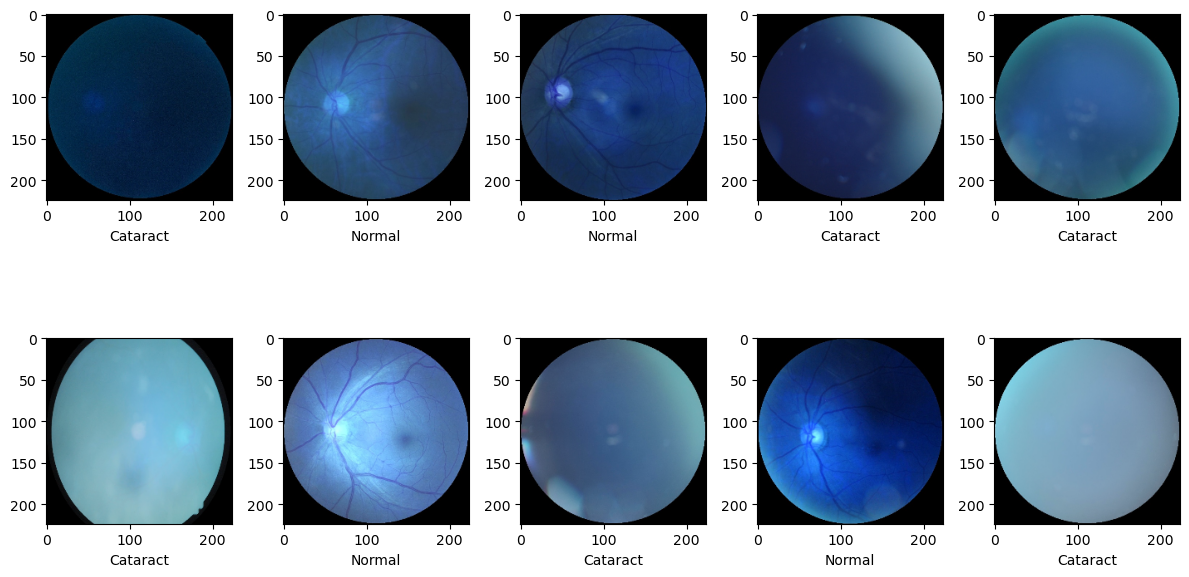

In [19]:
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(dataset)))
    image = dataset[sample][0]
    category = dataset[sample][1]
    if category== 0:
        label = "Normal"
    else:
        label = "Cataract"
    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel(label)
plt.tight_layout()    

In [20]:
# Feature and label
x = np.array([i[0] for i in dataset]).reshape(-1,image_size,image_size,3)
y = np.array([i[1] for i in dataset])

In [22]:
# Train and test split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2)

In [23]:
count_ones = np.sum(y_test == 1)
count_ones

116

#### Model Training:

In [26]:
vgg = VGG19(weights="imagenet",include_top = False,input_shape=(image_size,image_size,3))


80134624/80134624 [==============================] - 0s 0us/step


In [28]:
for layer in vgg.layers:
    layer.trainable = False
    
model = Sequential()
model.add(vgg)
model.add(Flatten())
model.add(Dense(1,activation="sigmoid"))

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1)                 25089     
                                                                 
Total params: 20,049,473
Trainable params: 25,089
Non-trainable params: 20,024,384
_________________________________________________________________


In [30]:
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

In [32]:
checkpoint = ModelCheckpoint("vgg19.h5",monitor="val_acc",verbose=1,save_best_only=True,
                             save_weights_only=False,period=1)
earlystop = EarlyStopping(monitor="val_acc",patience=5,verbose=1)

In [37]:
checkpoint = ModelCheckpoint(filepath='./Best Weights/best_model.hdf5',
                                monitor='val_accuracy',
                                verbose=1,
                                save_best_only=True,
                                mode='max')

history = model.fit(x_train, y_train,
                        batch_size=32,
                        epochs=50,
                        validation_data=(x_test, y_test),
                        callbacks=[checkpoint])

Epoch 1/50
27/28 [===========================>..] - ETA: 0s - loss: 21.1180 - accuracy: 0.8021
Epoch 1: val_accuracy improved from -inf to 0.71560, saving model to ./Best Weights/best_model.hdf5
28/28 [==============================] - 3s 100ms/step - loss: 5972.6064 - accuracy: 0.8023 - val_loss: 33.7713 - val_accuracy: 0.7156
Epoch 2/50
27/28 [===========================>..] - ETA: 0s - loss: 105.2786 - accuracy: 0.5336
Epoch 2: val_accuracy did not improve from 0.71560
28/28 [==============================] - 3s 91ms/step - loss: 42693.2148 - accuracy: 0.5310 - val_loss: 91.5641 - val_accuracy: 0.5780
Epoch 3/50
27/28 [===========================>..] - ETA: 0s - loss: 59.5329 - accuracy: 0.6956
Epoch 3: val_accuracy did not improve from 0.71560
28/28 [==============================] - 3s 91ms/step - loss: 61918.8008 - accuracy: 0.6931 - val_loss: 88.9903 - val_accuracy: 0.5917
Epoch 4/50
27/28 [===========================>..] - ETA: 0s - loss: 31.1857 - accuracy: 0.7685
Epoch 4: val

7/7 [==============================] - 1s 74ms/step - loss: 13.0907 - accuracy: 0.8807
Test loss: 13.090703964233398
Test accuracy: 0.8807339668273926


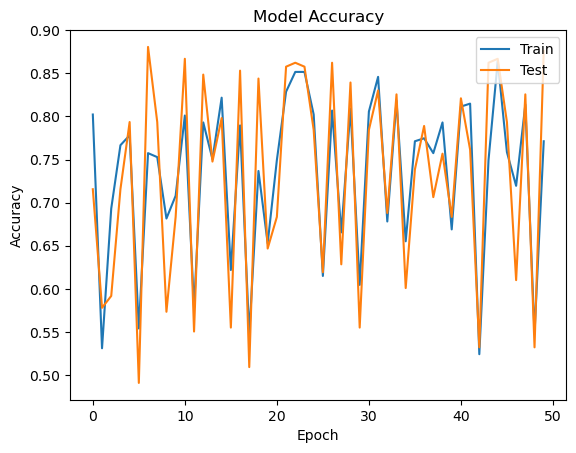

In [40]:
# Load the best weights
model.load_weights('./Best Weights/best_model.hdf5')

# Evaluate the model
score = model.evaluate(x_test, y_test, verbose=1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.savefig('./Best Weights/Model Accuracy.png')
plt.show()

In [41]:
# save model and architecture to single file
model.save('./Best Weights/Model.h5')

In [44]:
# Load the model
model = load_model('./Best Weights/Model.h5')

# Load the best weights
model.load_weights('./Best Weights/best_model.hdf5')

# Evaluate the model
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 1s 74ms/step - loss: 13.0907 - accuracy: 0.8807
Test loss: 13.090703964233398
Test accuracy: 0.8807339668273926
